In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
main_df = pd.read_csv('2023_Q3.2_AllData_Before_20231215.csv', header=0, index_col=0, low_memory=False).reset_index(drop=True)
print("Original shape: ")
print(main_df.shape)
main_df = main_df.drop_duplicates()

dropnas_df = main_df.dropna(axis=1, how="all")
dropnas_df = dropnas_df.dropna(subset=['Value'])

print("New shape after dropna: ")
print(dropnas_df.shape)

Original shape: 
(2668219, 83)
New shape after dropna: 
(2578431, 72)


In [3]:
# pd.set_option('Display.max_rows', None)
main_df['Age'].unique().tolist()

['ALLAGE',
 '<15Y',
 '65+',
 '15-64',
 '15+',
 '15-24',
 '25+',
 nan,
 '<18Y',
 '<16Y',
 '<10Y',
 '<6Y',
 '<5Y',
 '15-49',
 '<1Y',
 '<1M',
 '50+',
 '30-70',
 '15-19',
 '10-14',
 'M36T59',
 'M24T59',
 'M36T47',
 '25-54',
 '55-64',
 '25-74',
 '75+',
 '16-65',
 '20-24',
 '10+',
 '12+',
 '25-44',
 '45-54',
 '20-74',
 '12-24',
 '85+',
 '25-34',
 '35-44',
 '65-74',
 '75-84',
 '45-64',
 '3+',
 '12-14',
 '16+',
 '20+',
 '20-64',
 '6+',
 '5+',
 '14+',
 '18+',
 '6-65',
 '5-17',
 '5-14',
 '6-17',
 '10-17',
 '7-17',
 '_U',
 '18-29',
 '18-74',
 '1-14',
 '2-14',
 '5-12',
 '1-4',
 '<25Y',
 '<=45Y',
 '46+',
 '_X',
 '<35Y',
 '<45Y',
 'M24T35',
 'M12T23',
 'M48T59',
 '<8Y']

In [4]:
dropNs_df = dropnas_df[dropnas_df.Value != "N"]

In [5]:
def try_float_conversion(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        match = re.match(r'[<>]?\s*(\d+(\.\d+)?)', str(value))
        if match:
            number, _ = match.groups()
            return float(number)
        else:
            return str(value)
    
dropNs_df['Value'] = dropNs_df.Value.apply(try_float_conversion)
dropNs_df['Value'].apply(lambda x: isinstance(x, str)).value_counts()
dropNs_df = dropNs_df[dropNs_df.TimePeriod >= 2000]

C:\Users\jarrod.clark\AppData\Local\Temp\ipykernel_19052\2467013875.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropNs_df['Value'] = dropNs_df.Value.apply(try_float_conversion)


In [6]:
potential_drop_cols = ['Nature', 'Units', 'Level/Status', 'Name of international institution', 'IHR Capacity', 'Reporting Type', 'Observation Status', 'Sampling Stations', 'Parliamentary committees',
                 'Counterpart', 'Government_Name', 'Level_of_government', 'Population Group', 'Type of OFDI scheme']
just_drop_cols = ['ID', 'Goal', 'Target', 'ReleaseStatus', 'ReleaseName', 'SeriesID', 'isDSDSeries','SeriesDescription', 'SeriesObservationCount', 'ValueType',
                 'Time_Detail', 'UpperBound', 'LowerBound', 'BasePeriod', 'Source', 'FootNote', 'ObservationID', 'Nature', 'Units', 'Level/Status', 'Name of international institution', 
                  'IHR Capacity', 'Reporting Type', 'Observation Status', 'Sampling Stations', 'Parliamentary committees',
                 'Counterpart', 'Government_Name', 'Level_of_government', 'Population Group', 'Type of OFDI scheme']
drop_rows_and_cols = ['Cities']

In [7]:
age_map = {'<15Y': 'Child','65+': 'Elderly','15-64': 'Adult','15+': 'Adult','15-24': 'Young Adult','25+': 'Adult','<18Y': 'Child','<16Y': 'Child','<10Y': 'Child','<6Y': 'Child','<5Y': 'Child',
           '15-49': 'Adult','<1Y': 'Child','<1M': 'Child','50+': 'Adult','30-70': 'Adult','15-19': 'Young Adult','10-14': 'Child','M36T59': 'Adult','M24T59': 'Adult','M36T47': 'Adult','25-54': 'Adult',
           '55-64': 'Adult','25-74': 'Adult','75+': 'Elderly','16-65': 'Adult', '20-24': 'Young Adult', '10+': 'Child', '12+': 'Child', '25-44': 'Adult', '45-54': 'Adult', '20-74': 'Adult', 
           '12-24': 'Young Adult', '85+': 'Elderly', '25-34': 'Adult', '35-44': 'Adult', '65-74': 'Elderly', '75-84': 'Elderly', '45-64': 'Adult', '3+': 'Child', '12-14': 'Child', '16+': 'Young Adult', 
           '20+': 'Young Adult', '20-64': 'Adult', '6+': 'Child', '5+': 'Child', '14+': 'Child', '18+': 'Young Adult', '6-65': 'ALLAGE', '5-17': 'Child', '5-14': 'Child', '6-17': 'Child', '10-17': 'Child', 
           '7-17': 'Child', '18-29': 'Young Adult', '18-74': 'Adult', '1-14': 'Child', '2-14': 'Child', '5-12': 'Child', '1-4': 'Child', '<25Y': 'Young Adult', '<=45Y' : 'Adult', '46+': 'Adult', 
           '<35Y': 'Adult', '<45Y': 'Adult', 'M24T35': 'Adult', 'M12T23': 'Child', 'M48T59': 'Adult', '<8Y': 'Child'}
dropNs_df['Age'] = dropNs_df['Age'].map(age_map)

mapping = {
    'SEX': 'Demographic Characteristics','AGE': 'Demographic Characteristics','RACECOLR': 'Demographic Characteristics','ETH': 'Demographic Characteristics','ORIGIN': 'Demographic Characteristics',
    'MARFAM': 'Demographic Characteristics','WEDLOCK': 'Demographic Characteristics','PREGY': 'Demographic Characteristics','SOCIOECON': 'Socioeconomic Status','MIG': 'Socioeconomic Status',
    'LANDIA': 'Socioeconomic Status','NETW': 'Socioeconomic Status','WORK': 'Socioeconomic Status','EDU': 'Socioeconomic Status','RELIGION': 'Religious and Cultural Discrimination',
    'ETHCUL': 'Religious and Cultural Discrimination','HEAILLINJ': 'Health and Physical Condition','PHYSCOND': 'Health and Physical Condition','HEALTH': 'Health and Physical Condition',
    'OTHER': 'Other/unspecified','DIS': 'Other/unspecified','SEXO': 'Other/unspecified','DISHEA': 'Other/unspecified','POLVIEW': 'Other/unspecified','ETHIO': 'Other/unspecified',
    'MAR': 'Other/unspecified','RES': 'Other/unspecified','ETHCOLLAN': 'Other/unspecified','ETHRACECOLLAN': 'Other/unspecified','GENID': 'Other/unspecified','SEXGENID': 'Other/unspecified',
    'CLOTH': 'Other/unspecified','ETHCOLLANNAL': 'Other/unspecified','FAM': 'Other/unspecified','NATION': 'Other/unspecified',
}

dropNs_df['Grounds of discrimination'] = dropNs_df['Grounds of discrimination'].map(mapping)

In [8]:
GeoAreasToDrop = ['Residual/unallocated ODA: Central Asia and Southern Asia', 'Residual/unallocated ODA: Eastern and South-eastern Asia', 'Residual/unallocated ODA: Latin America and the Caribbean'
                 'Residual/unallocated ODA: Oceania excl. Aus. and N. Zealand', 'Residual/unallocated ODA: Sub-Saharan Africa', 'Residual/unallocated ODA: Western Asia and Northern Africa', 
                 'Residual/unallocated ODA: Unspecified, developing countries','Residual/unallocated ODA: Northern America and Europe', 'Large Marine Ecosystem: East Bering Sea', 
                 'Large Marine Ecosystem: Gulf of Alaska', 'Large Marine Ecosystem: California Current', 'Large Marine Ecosystem: Gulf of California', 'Large Marine Ecosystem: Gulf of Mexico', 
                 'Large Marine Ecosystem: Southeast U.S. Continental Shelf', 'Large Marine Ecosystem: Northeast U.S. Continental Shelf', 'Large Marine Ecosystem: Scotian Shelf', 
                 'Large Marine Ecosystem: Labrador - Newfoundland', 'Large Marine Ecosystem: Insular Pacific-Hawaiian', 'Large Marine Ecosystem: Pacific Central-American Coastal', 
                 'Large Marine Ecosystem: Caribbean Sea', 'Large Marine Ecosystem: Humboldt Current', 'Large Marine Ecosystem: Patagonian Shelf', 'Large Marine Ecosystem: South Brazil Shelf', 
                 'Large Marine Ecosystem: East Brazil Shelf', 'Large Marine Ecosystem: North Brazil Shelf', 'Large Marine Ecosystem: Canadian Eastern Arctic - West Greenland', 'Large Marine Ecosystem: Greenland Sea', 
                 'Large Marine Ecosystem: Barents Sea', 'Large Marine Ecosystem: Norwegian Sea', 'Large Marine Ecosystem: North Sea' 'Large Marine Ecosystem: Baltic Sea', 'Large Marine Ecosystem: Celtic-Biscay Shelf', 
                 'Large Marine Ecosystem: Iberian Coastal', 'Large Marine Ecosystem: Mediterranean Sea', 'Large Marine Ecosystem: Canary Current', 'Large Marine Ecosystem: Guinea Current', 'Large Marine Ecosystem: Benguela Current', 
                 'Large Marine Ecosystem: Agulhas Current', 'Large Marine Ecosystem: Somali Coastal Current', 'Large Marine Ecosystem: Arabian Sea' 'Large Marine Ecosystem: Red Sea', 'Large Marine Ecosystem: Bay of Bengal', 
                 'Large Marine Ecosystem: Gulf of Thailand', 'Large Marine Ecosystem: South China Sea', 'Large Marine Ecosystem: Sulu-Celebes Sea', 'Large Marine Ecosystem: Indonesian Sea', 'Large Marine Ecosystem: North Australian Shelf', 
                 'Large Marine Ecosystem: Northeast Australian Shelf', 'Large Marine Ecosystem: East Central Australian Shelf', 'Large Marine Ecosystem: Southeast Australian Shelf', 'Large Marine Ecosystem: South West Australian Shelf', 
                 'Large Marine Ecosystem: West Central Australian Shelf', 'Large Marine Ecosystem: Northwest Australian Shelf', 'Large Marine Ecosystem: New Zealand Shelf', 'Large Marine Ecosystem: East China Sea', 
                 'Large Marine Ecosystem: Yellow Sea', 'Large Marine Ecosystem: Kuroshio Current', 'Large Marine Ecosystem: Sea of Japan', 'Large Marine Ecosystem: Oyashio Current', 'Large Marine Ecosystem: Sea of Okhotsk', 
                 'Large Marine Ecosystem: West Bering Sea', 'Large Marine Ecosystem: Northern Bering - Chukchi Seas', 'Large Marine Ecosystem: Beaufort Sea', 'Large Marine Ecosystem: East Siberian Sea', 
                 'Large Marine Ecosystem: Laptev Sea' 'Large Marine Ecosystem: Kara Sea', 'Large Marine Ecosystem: Iceland Shelf and Sea', 'Large Marine Ecosystem: Faroe Plateau', 'Large Marine Ecosystem: Antarctica',
                 'Large Marine Ecosystem: Black Sea', 'Large Marine Ecosystem: Hudson Bay Complex', 'Large Marine Ecosystem: Central Arctic', 'Large Marine Ecosystem: Aleutian Islands', 'Large Marine Ecosystem: Canadian High Arctic - North Greenland', 
                 'FAO Major Fishing Area: Pacific, Eastern Central', 'FAO Major Fishing Area: Pacific, Northeast', 'FAO Major Fishing Area: Pacific, Northwest', 'FAO Major Fishing Area: Pacific, Western Central', 
                 'FAO Major Fishing Area: Pacific, Southwest', 'FAO Major Fishing Area: Atlantic, Northwest', 'FAO Major Fishing Area: Atlantic, Northeast', 'FAO Major Fishing Area: Indian Ocean, Eastern', 
                 'FAO Major Fishing Area: Atlantic, Southeast', 'FAO Major Fishing Area: Indian Ocean, Western', 'FAO Major Fishing Area: Atlantic, Western Central', 'FAO Major Fishing Area: Atlantic, Eastern Central', 
                 'FAO Major Fishing Area: Atlantic, Southwest', 'FAO Major Fishing Area: Pacific, Southeast', 'FAO Major Fishing Area: Mediterranean and Black Sea', 'Developed regions (Europe, Cyprus, Israel, Northern America, Japan, Australia & New Zealand)',
                 'Developing regions', 'Eastern Asia (excluding Japan)', 'Western Asia (exc. Armenia, Azerbaijan, Cyprus, Israel and Georgia)', 'Sub-Saharan Africa', 'Western Asia', 'Northern Europe', 'Western Europe',
                 'Central Asia', 'Central and Southern Asia', 'South-Eastern Asia', 'Southern Europe', 'Middle Africa', 'Southern Africa', 'Americas', 'Northern America', 'Central America', 'Eastern Africa', 'Northern Africa',
                 'World', 'Africa', 'South America', 'Oceania', 'Western Africa', 'Regional Centres (FAO)', 'International Centers (FAO)', 'Unallocated by country', 'Landlocked developing countries (LLDCs)', 'Least Developed Countries (LDCs)',
                 'Oceania (exc. Australia and New Zealand)', 'Eastern Asia (excluding Japan and China)', 'Latin America and the Caribbean', 'Small island developing States (SIDS)', 'Northern Africa and Western Asia', 'Northern Africa and Western Asia',
                 'Europe and Northern America', 'Latin America and the Caribbean', 'Other non-specified areas in Eastern Asia', 'Caucasus and Central Asia', 'Eastern and South-Eastern Asia', 'Sub-Saharan Africa (inc. Sudan)', 'Northern Africa (exc. Sudan)',
                 'Large Marine Ecosystem: Arabian Sea', 'Large Marine Ecosystem: Kara Sea', 'Large Marine Ecosystem: Laptev Sea', 'Large Marine Ecosystem: Red Sea', 'Large Marine Ecosystem: North Sea', 'Large Marine Ecosystem: Baltic Sea', 'Latin America',
                 'Development Assistance Committee members (DAC)', 'Other Africa (IEA)', 'Other non-OECD Americas', 'European Union (EU) Institutions', 'Sark', 'Other non-OECD Oceania', 'Other non-OECD Asia', 'Africa', 'British Indian Ocean Territory', 
                 'Asia', 'Eastern Asia', 'Eastern Europe', 'European Union', 'French Southern Territories', 'Iraq (Central Iraq)', 'Iraq (Kurdistan Region)', 'Middle East (ILO)', 'Middle East and North Africa (ILO)', 'North America (ILO)',
                 'ODA residual', 'Residual/unallocated ODA: Latin America and the Caribbean', 'Residual/unallocated ODA: Oceania excl. Aus. and N. Zealand', 'Southern Asia (excluding India)', '']

dropGeoAreasdf = dropNs_df[~dropNs_df['GeoAreaName'].isin(GeoAreasToDrop)]

In [9]:
dropcols_df = dropGeoAreasdf.drop(columns=just_drop_cols, axis=1)
df = dropcols_df[dropcols_df.Cities.isna()]
df = df.drop('Cities', axis=1)

In [10]:
indicators_droplist = ['4.2.1', '10.7.1', '13.2.1', '13.b.1', '14.2.1', '16.7.2']
series_droplist = ['SG_DSR_SFDRR', 'SP_PSR_OSATIS_PRM', 'SP_PSR_SATIS_GOV', 'SP_PSR_SATIS_HLTH', 'SP_PSR_SATIS_PRM', 'SP_PSR_SATIS_SEC', ]

df = df[~df.Indicator.isin(indicators_droplist)]
df = df[~df.SeriesCode.isin(series_droplist)]

In [11]:
discriminator_df = df.drop(['GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value'], axis=1)
# discriminator_df['discriminator_combo'] = discriminator_df.apply(lambda row: tuple(row.dropna()), axis=1)
discriminator_df['discriminator_combo'] = discriminator_df.apply(lambda row: tuple((col, val) for col, val in row.dropna().items()), axis=1)
df['discriminator_combo'] = discriminator_df['discriminator_combo']
print("Discriminator DF shape: ")
print(discriminator_df.shape)
unconditioned_df = df[['GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value', 'discriminator_combo']]
print("Final shape before pivot: ")
print(unconditioned_df.shape)

conditioned_df = unconditioned_df.pivot_table(index=['GeoAreaName', 'TimePeriod'],
                                             columns='discriminator_combo',
                                             values='Value',
                                             aggfunc='mean').reset_index()

print(conditioned_df.shape)

Discriminator DF shape: 
(2195918, 37)
Final shape before pivot: 
(2195918, 5)
(6265, 2428)


In [12]:
# for col in potential_drop_cols:
#     just_drop_cols.append(col)
#     print(just_drop_cols)
#     try:
#         dropcols_df = dropNs_df.drop(columns=just_drop_cols, axis=1)
#         df = dropcols_df[dropcols_df.Cities.isna()]
#         df = df.drop('Cities', axis=1)
        
#         discriminator_df = df.drop(['GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value'], axis=1)
#         # discriminator_df['discriminator_combo'] = discriminator_df.apply(lambda row: tuple(row.dropna()), axis=1)
#         discriminator_df['discriminator_combo'] = discriminator_df.apply(lambda row: tuple((col, val) for col, val in row.dropna().items()), axis=1)
#         df['discriminator_combo'] = discriminator_df['discriminator_combo']
#         print("Discriminator DF shape: ")
#         print(discriminator_df.shape)
#         unconditioned_df = df[['GeoAreaCode', 'GeoAreaName', 'TimePeriod', 'Value', 'discriminator_combo']]
#         print("Final shape before pivot: ")
#         print(unconditioned_df.shape)
        
#         conditioned_df = unconditioned_df.pivot_table(index=['GeoAreaName', 'TimePeriod'],
#                                                      columns='discriminator_combo',
#                                                      values='Value',
#                                                      aggfunc='mean').reset_index()
#     except:
#         print("The bad column is: " + col)
#     print(conditioned_df.shape)

In [13]:
conditioned_df.dropna(axis=1, how="all")
print(conditioned_df.shape)
conditioned_df.to_csv("2d SDG Dataset.csv", index=False)

(6265, 2428)


In [14]:
sub_df = conditioned_df[(conditioned_df.GeoAreaName == "Brazil") & (conditioned_df.TimePeriod.isin([2000, 2005, 2010, 2015, 2020]))]
sub_df.shape

(5, 2428)

In [15]:
sub_df.dropna(how="all", axis=1, inplace=True)
sub_df.shape

C:\Users\jarrod.clark\AppData\Local\Temp\ipykernel_19052\1513320170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df.dropna(how="all", axis=1, inplace=True)


(5, 1221)

In [16]:
pd.set_option("Display.max_columns", None)
sub_df

discriminator_combo,GeoAreaName,TimePeriod,"((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Age, Adult), (Location, ALLAREA), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Age, Child), (Location, ALLAREA), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Age, Elderly), (Location, ALLAREA), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Location, ALLAREA), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Location, ALLAREA), (Sex, FEMALE))","((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Location, ALLAREA), (Sex, MALE))","((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Location, RURAL), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Location, URBAN), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_EMP1), (Age, Adult), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_EMP1), (Age, Adult), (Sex, FEMALE))","((Indicator, 1.1.1), (SeriesCode, SI_POV_EMP1), (Age, Adult), (Sex, MALE))","((Indicator, 1.1.1), (SeriesCode, SI_POV_EMP1), (Age, Young Adult), (Sex, BOTHSEX))","((Indicator, 1.1.1), (SeriesCode, SI_POV_EMP1), (Age, Young Adult), (Sex, FEMALE))","((Indicator, 1.1.1), (SeriesCode, SI_POV_EMP1), (Age, Young Adult), (Sex, MALE))","((Indicator, 1.3.1), (SeriesCode, SI_COV_BENFTS), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_CHLD), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_DISAB), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_DISAB), (Sex, FEMALE))","((Indicator, 1.3.1), (SeriesCode, SI_COV_DISAB), (Sex, MALE))","((Indicator, 1.3.1), (SeriesCode, SI_COV_LMKT), (Quantile, Q1))","((Indicator, 1.3.1), (SeriesCode, SI_COV_LMKT), (Quantile, _T))","((Indicator, 1.3.1), (SeriesCode, SI_COV_MATNL), (Sex, FEMALE))","((Indicator, 1.3.1), (SeriesCode, SI_COV_PENSN), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_PENSN), (Sex, FEMALE))","((Indicator, 1.3.1), (SeriesCode, SI_COV_PENSN), (Sex, MALE))","((Indicator, 1.3.1), (SeriesCode, SI_COV_POOR), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_SOCAST), (Quantile, Q1))","((Indicator, 1.3.1), (SeriesCode, SI_COV_SOCAST), (Quantile, _T))","((Indicator, 1.3.1), (SeriesCode, SI_COV_SOCINS), (Quantile, Q1))","((Indicator, 1.3.1), (SeriesCode, SI_COV_SOCINS), (Quantile, _T))","((Indicator, 1.3.1), (SeriesCode, SI_COV_UEMP), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_VULN), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_WKINJRY), (Sex, BOTHSEX))","((Indicator, 1.3.1), (SeriesCode, SI_COV_WKINJRY), (Sex, FEMALE))","((Indicator, 1.3.1), (SeriesCode, SI_COV_WKINJRY), (Sex, MALE))","((Indicator, 1.4.1), (SeriesCode, SP_ACS_BSRVH2O), (Location, ALLAREA))","((Indicator, 1.4.1), (SeriesCode, SP_ACS_BSRVH2O), (Location, RURAL))","((Indicator, 1.4.1), (SeriesCode, SP_ACS_BSRVH2O), (Location, URBAN))","((Indicator, 1.4.1), (SeriesCode, SP_ACS_BSRVSAN), (Location, ALLAREA))","((Indicator, 1.4.1), (SeriesCode, SP_ACS_BSRVSAN), (Location, RURAL))","((Indicator, 1.4.1), (SeriesCode, SP_ACS_BSRVSAN), (Location, URBAN))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_AFFCT))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_DAFF))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_IJILN))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_MISS))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_MMHN))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_MORT))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_MTMP))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_PDAN))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_PDLN))","((Indicator, 1.5.1), (SeriesCode, VC_DSR_PDYN))","((Indicator, 1.5.2), (SeriesCode, VC_DSR_AGLH))","((Indicator, 1.5.2), (SeriesCode, VC_DSR_CHLN))","((Indicator, 1.5.2), (SeriesCode, VC_DSR_CILN))","((Indicator, 1.5.2), (SeriesCode, VC_DSR_DDPA))","((Indicator, 1.5.2), (SeriesCode, VC_DSR_GDPLS))","((Indicator, 1.5.2), (SeriesCode, VC_DSR_LSGP))","((Indicator, 1.a.1), (SeriesCode, DC_ODA_POVLG))","((Indicator, 1.a.2), (SeriesCode, SD_XPD_ESED

In [17]:
sub_df.to_csv("Brazil Subset.csv", index=False)

<Axes: xlabel='discriminator_combo'>

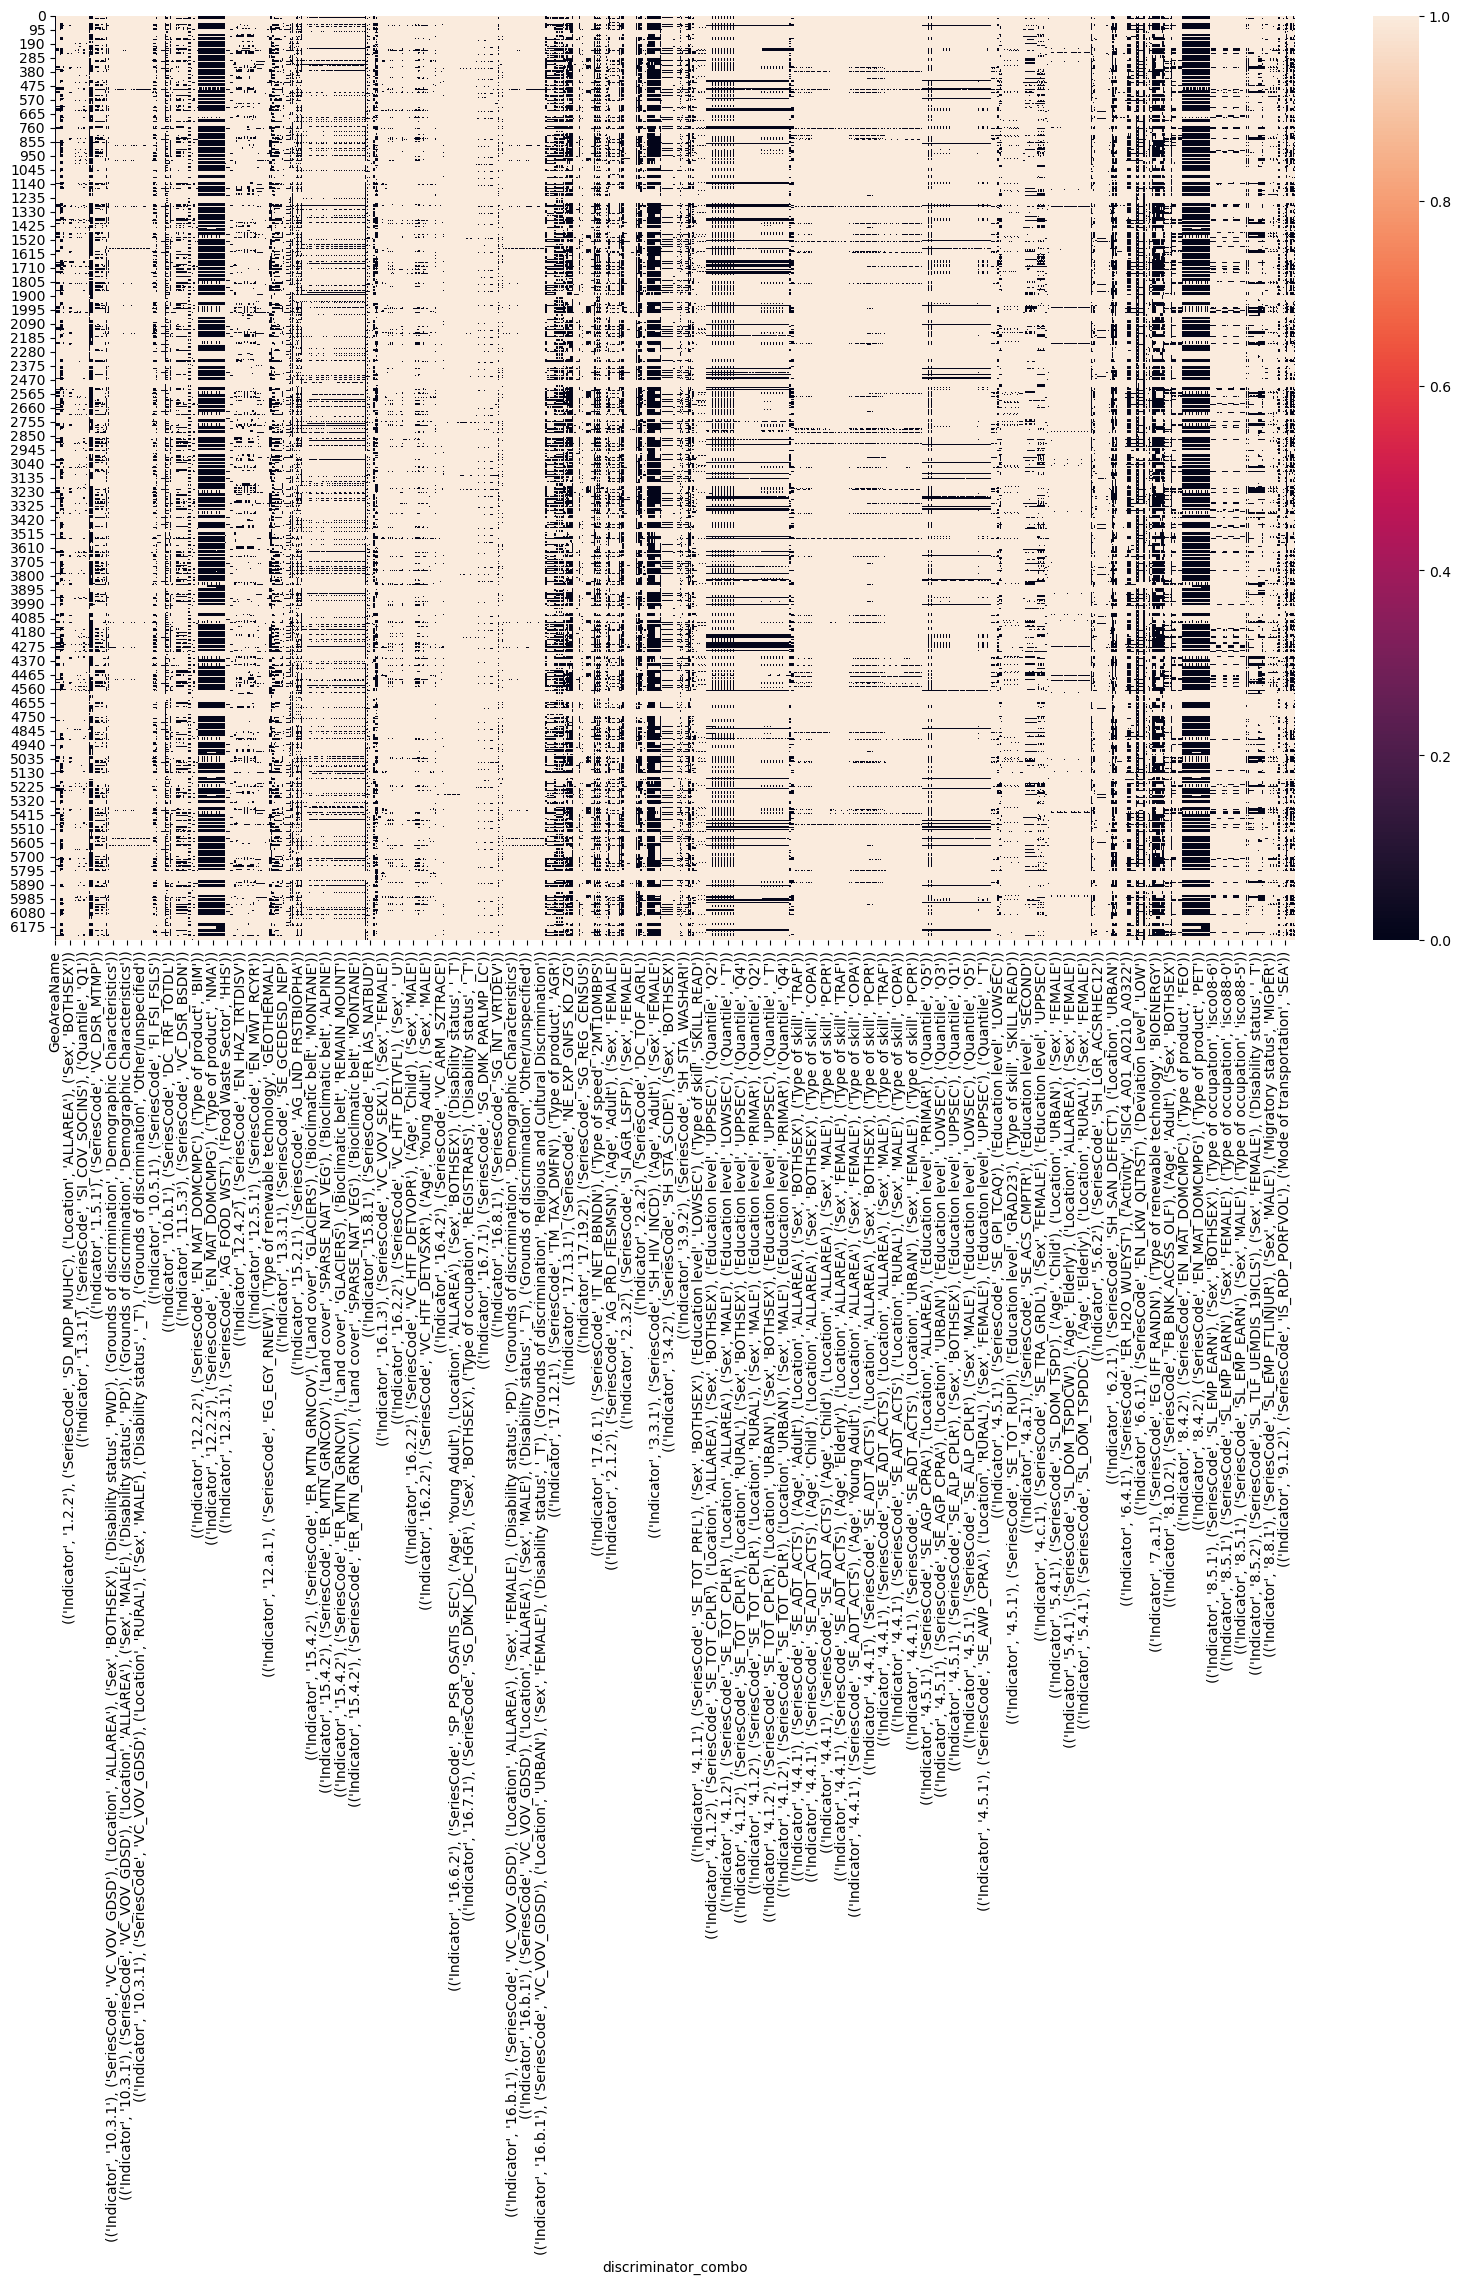

In [18]:
plt.figure(figsize=(20, 12))
sns.heatmap(conditioned_df.isnull())

In [19]:
pd.set_option('Display.max_rows', None)
conditioned_df.notna().sum()

discriminator_combo
GeoAreaName                                                                                                                                                                            6265
TimePeriod                                                                                                                                                                             6265
((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Age, Adult), (Location, ALLAREA), (Sex, BOTHSEX))                                                                                      943
((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Age, Child), (Location, ALLAREA), (Sex, BOTHSEX))                                                                                      939
((Indicator, 1.1.1), (SeriesCode, SI_POV_DAY1), (Age, Elderly), (Location, ALLAREA), (Sex, BOTHSEX))                                                                                    946
((Indicator, 1.1.1), (SeriesCode, SI_POV